In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scripts.helpers as helpers

helpers.add_backend_to_path()

In [76]:
import pymongo
from pymongo import MongoClient
from dotenv import load_dotenv
load_dotenv()
import os

connection_string = os.getenv("MONGO_CONNECTION_STRING")

client = MongoClient(connection_string)
db = client.get_database("course_feedback")

db.recommendation_feedback.create_index([("user_id", pymongo.ASCENDING)])
db.recommendation_feedback.create_index([("course", pymongo.ASCENDING)])
db.user_feedback.create_index([("faculty", pymongo.ASCENDING)])

print("Connected to MongoDB")

Connected to MongoDB


In [77]:
import numpy as np
rec_feedbacks = list(db.recommendation_feedback.find())

# Convert to DataFrame
rec_data = []
for feedback in rec_feedbacks:
    rec_data.append({
        'user_id': feedback['user_id'],
        'action': feedback['action'],
        'model': feedback['model'],
        'course': feedback['course'],
        'liked': feedback.get('liked_recommendations', []),
        'disliked': feedback.get('disliked_recommendations', []), 
        'skipped': feedback.get('skipped_recommendations', []),
        'phrases': feedback.get('phrases', []),
        'recommended_from': feedback.get('recommended_from', []),
        'timestamp': feedback['timestamp']
    })
rec_df = pd.DataFrame(rec_data)

print(rec_df.head())


                                user_id action                  model  course  \
0  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPN112   
1  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  DSMA06   
2  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPN122   
3  832e69de-3160-4f9e-ab18-6500be557613   skip  max_with_combinations  JPNN11   
4  832e69de-3160-4f9e-ab18-6500be557613   like  max_with_combinations  JPNN30   

                                               liked disliked  \
0  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
1  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
2  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
3  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   
4  [LgBB01, DSMB23, PB009, p9045, IB015, PB016, P...  [IB111]   

                            skipped phrases  recommended_from  \
0                                []      []          [JPN

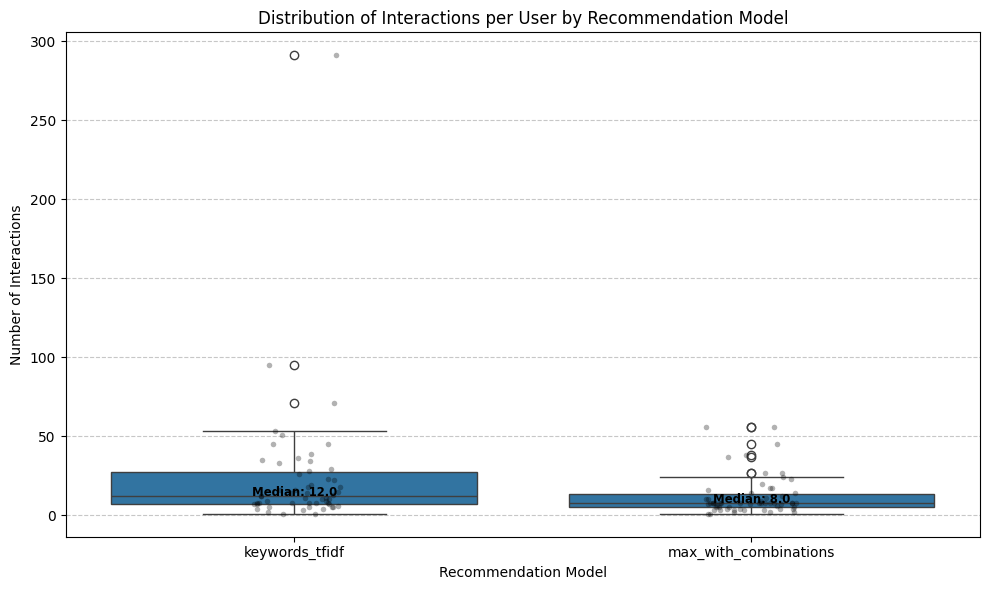

In [78]:
def boxplot_actions_model():
    # Create a boxplot showing the distribution of interactions per user for each model
    plt.figure(figsize=(10, 6))

    # Calculate number of interactions per user for each model
    interactions_per_user = rec_df.groupby(['model', 'user_id']).size().reset_index(name='interactions')

    # Create the boxplot
    sns.boxplot(x='model', y='interactions', data=interactions_per_user)

    # Add individual data points with jitter for better visibility
    sns.stripplot(x='model', y='interactions', data=interactions_per_user, 
                size=4, color='black', alpha=0.3, jitter=True)

    # Add labels and title
    plt.title('Distribution of Interactions per User by Recommendation Model')
    plt.xlabel('Recommendation Model')
    plt.ylabel('Number of Interactions')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Calculate and display median values
    medians = interactions_per_user.groupby('model')['interactions'].median()
    for i, model in enumerate(medians.index):
        plt.text(i, medians[model], f'Median: {medians[model]:.1f}', 
                horizontalalignment='center', size='small', color='black', weight='semibold')

    plt.tight_layout()
    plt.show()
boxplot_actions_model()

In [79]:
# Filter out users with more than 75 actions
user_action_counts = rec_df.groupby('user_id').size()
users_to_keep = user_action_counts[user_action_counts <= 75].index
users_to_keep = user_action_counts[user_action_counts > 3].index

# Create filtered dataframe
filtered_rec_df = rec_df[rec_df['user_id'].isin(users_to_keep)]

# Print information about filtered users
filtered_out_users = len(rec_df['user_id'].unique()) - len(users_to_keep)
filtered_out_actions = len(rec_df) - len(filtered_rec_df)

print(f"\nFiltered out {filtered_out_users} users with more than actions or less than 4 actions")
print(f"Removed {filtered_out_actions} actions ({filtered_out_actions/len(rec_df)*100:.2f}% of total)")
print(f"Remaining users: {len(filtered_rec_df['user_id'].unique())}")

# Update rec_df to use filtered data
rec_df = filtered_rec_df


Filtered out 13 users with more than actions or less than 4 actions
Removed 29 actions (1.46% of total)
Remaining users: 98


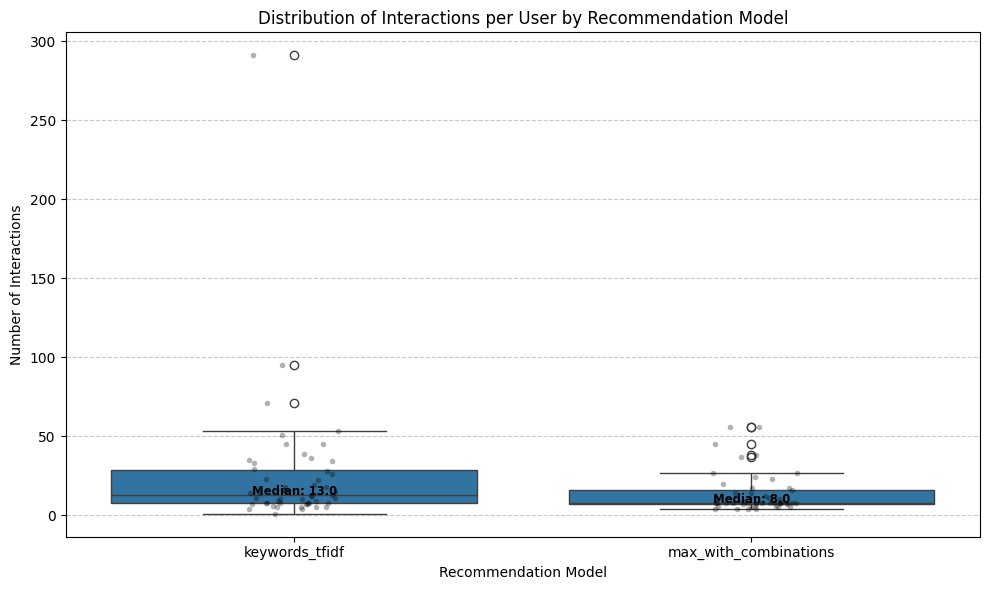

In [80]:
boxplot_actions_model()

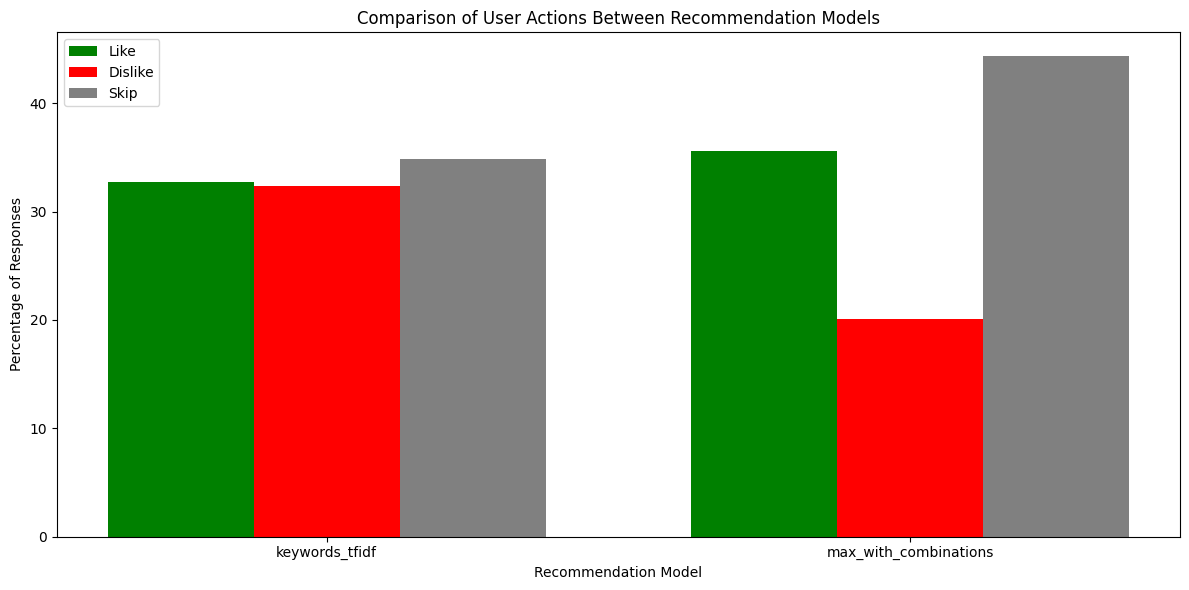


Number of unique users per model:
model
keywords_tfidf           51
max_with_combinations    48
Name: user_id, dtype: int64

Total number of interactions per model:
model
keywords_tfidf           1287
max_with_combinations     672
dtype: int64

Average interactions per user for each model:
model
keywords_tfidf           25.24
max_with_combinations    14.00
dtype: float64

Raw numbers of actions per model:
action                 dislike  like  skip
model                                     
keywords_tfidf             417   421   449
max_with_combinations      135   239   298

Percentage distribution of actions per model:
action                 dislike   like   skip
model                                       
keywords_tfidf           32.40  32.71  34.89
max_with_combinations    20.09  35.57  44.35


In [87]:
# Group by model and action to get counts
model_stats = rec_df.groupby(['model', 'action']).size().unstack(fill_value=0)

# Calculate percentages for each model
model_percentages = model_stats.div(model_stats.sum(axis=1), axis=0) * 100

# Plot comparison
plt.figure(figsize=(12, 6))

# Create grouped bar chart
x = np.arange(len(model_stats.index))
width = 0.25

for i, action in enumerate(['like', 'dislike', 'skip']):
    if action in model_percentages.columns:
        color = 'green' if action == 'like' else 'red' if action == 'dislike' else 'grey'
        plt.bar(x + i*width, model_percentages[action], width, 
                label=action.capitalize(), color=color)

plt.xlabel('Recommendation Model')
plt.ylabel('Percentage of Responses')
plt.title('Comparison of User Actions Between Recommendation Models')
plt.xticks(x + width, model_stats.index)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate unique users per model
unique_users = rec_df.groupby('model')['user_id'].nunique()
print("\nNumber of unique users per model:")
print(unique_users)

# Calculate total interactions per model
total_interactions = rec_df.groupby('model').size()
print("\nTotal number of interactions per model:")
print(total_interactions)

# Calculate average interactions per user for each model
avg_interactions = total_interactions / unique_users
print("\nAverage interactions per user for each model:")
print(avg_interactions.round(2))
print("\nRaw numbers of actions per model:")
print(model_stats)
print("\nPercentage distribution of actions per model:")
print(model_percentages.round(2))


In [82]:
# Get initial preferences from first interaction of each user
first_interactions = rec_df.sort_values('timestamp').groupby('user_id').first()

# Initialize sets for initially liked and disliked courses
initial_likes = set()
initial_dislikes = set()

# Initialize dictionaries to count likes and dislikes per course
course_likes_counts = {}
course_dislikes_counts = {}

# Combine liked and disliked courses from first interactions
for _, row in first_interactions.iterrows():
    if isinstance(row['liked'], list):
        initial_likes.update(row['liked'])
        for course in row['liked']:
            course_likes_counts[course] = course_likes_counts.get(course, 0) + 1
            
    if isinstance(row['disliked'], list):    
        initial_dislikes.update(row['disliked'])
        for course in row['disliked']:
            course_dislikes_counts[course] = course_dislikes_counts.get(course, 0) + 1

print("\nInitial preferences analysis:")
print(f"Number of initially liked courses: {len(initial_likes)}")
print(f"Number of initially disliked courses: {len(initial_dislikes)}")
print(f"Number of courses with initial preferences: {len(initial_likes | initial_dislikes)}")
print(f"Number of courses both liked and disliked: {len(initial_likes & initial_dislikes)}")

print("\nCourses with most likes:")
for course, count in sorted(course_likes_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{course}: {count} likes")

print("\nCourses with most dislikes:")
for course, count in sorted(course_dislikes_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{course}: {count} dislikes")



Initial preferences analysis:
Number of initially liked courses: 218
Number of initially disliked courses: 71
Number of courses with initial preferences: 250
Number of courses both liked and disliked: 39

Courses with most likes:
IB111: 23 likes
IB002: 17 likes
PB071: 16 likes
IB031: 13 likes
IB015: 12 likes

Courses with most dislikes:
PB152: 15 dislikes
PB156: 13 dislikes
IB000: 11 dislikes
MB141: 8 dislikes
PV080: 6 dislikes


In [83]:
from app.courses import CourseClient

course_client = CourseClient(os.path.join("..", "web", "backend", "assets", "courses"))

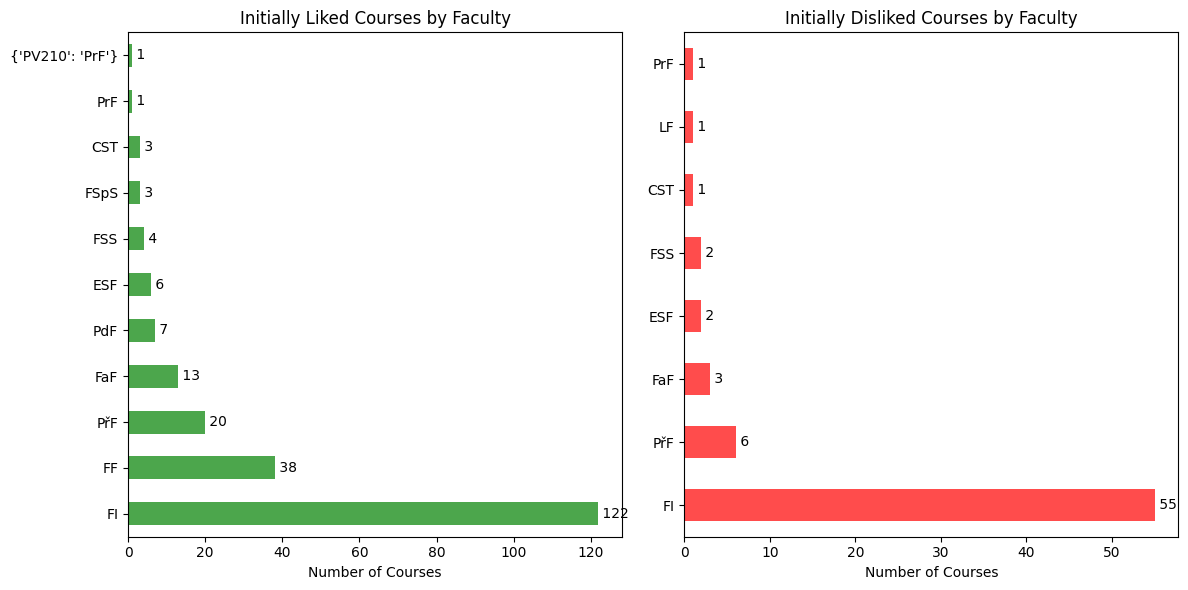


Faculty distribution statistics:
FI     122
FF      38
PřF     20
FaF     13
PdF      7
Name: count, dtype: int64
FI     55
PřF     6
FaF     3
ESF     2
FSS     2
Name: count, dtype: int64


In [84]:
# Get faculty information for initially liked and disliked courses
liked_faculties = []
disliked_faculties = []

# Process liked courses
for course_code in initial_likes:
    course = course_client.get_course_by_code(course_code)
    if course:
        liked_faculties.append(course.FACULTY)

# Process disliked courses        
for course_code in initial_dislikes:
    course = course_client.get_course_by_code(course_code)
    if course:
        disliked_faculties.append(course.FACULTY)

# Convert to pandas Series and get counts
liked_faculty_counts = pd.Series(liked_faculties).value_counts()
disliked_faculty_counts = pd.Series(disliked_faculties).value_counts()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot liked faculties
liked_faculty_counts.plot(kind='barh', ax=ax1, color='green', alpha=0.7)
ax1.set_title('Initially Liked Courses by Faculty')
ax1.set_xlabel('Number of Courses')

# Add count labels to liked faculties bars
for i, v in enumerate(liked_faculty_counts):
    ax1.text(v, i, f' {v}', va='center')

# Plot disliked faculties
disliked_faculty_counts.plot(kind='barh', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Initially Disliked Courses by Faculty')
ax2.set_xlabel('Number of Courses')

# Add count labels to disliked faculties bars
for i, v in enumerate(disliked_faculty_counts):
    ax2.text(v, i, f' {v}', va='center')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nFaculty distribution statistics:")
print(liked_faculty_counts.head())
print(disliked_faculty_counts.head())



Analyzing most liked and disliked courses...


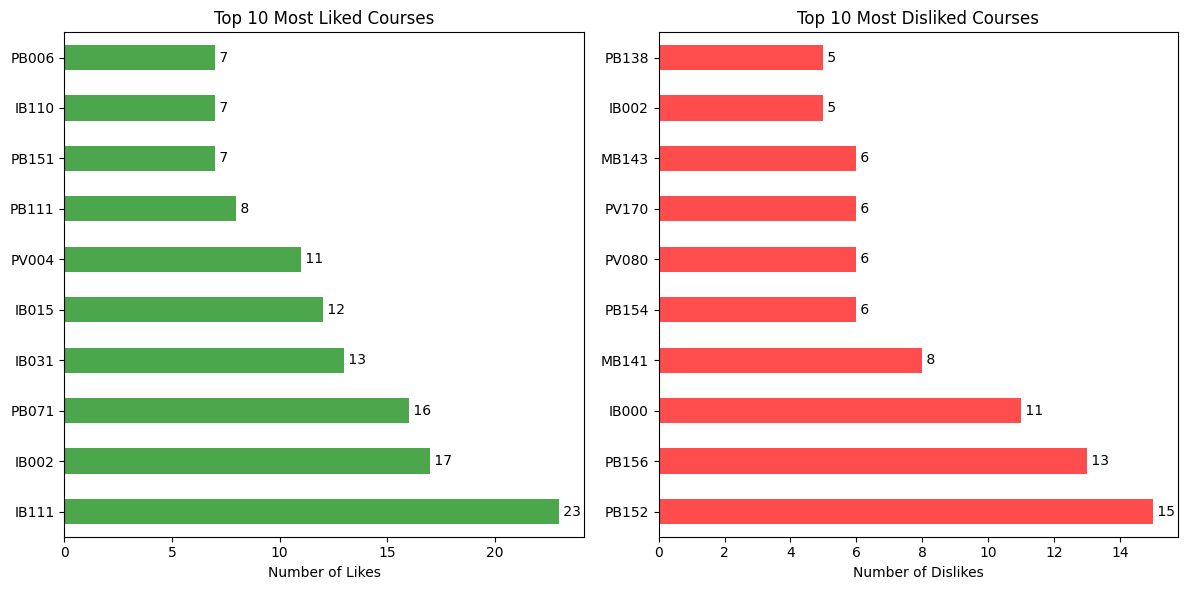


Most liked courses:
IB111 (Základy programování): 23
IB002 (Algoritmy a datové struktury I): 17
PB071 (Principy nízkoúrovňového programování): 16
IB031 (Úvod do strojového učení): 13
IB015 (Neimperativní programování): 12

Most disliked courses:
PB152 (Operační systémy): 15
PB156 (Počítačové sítě): 13
IB000 (Matematické základy informatiky): 11
MB141 (Lineární algebra a diskrétní matematika): 8
PB154 (Základy databázových systémů): 6


In [85]:
# Analyze most liked and disliked courses
print("\nAnalyzing most liked and disliked courses...")

# Convert to pandas Series and sort
liked_course_counts = pd.Series(course_likes_counts).sort_values(ascending=False)
disliked_course_counts = pd.Series(course_dislikes_counts).sort_values(ascending=False)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot liked courses
liked_course_counts.head(10).plot(kind='barh', ax=ax1, color='green', alpha=0.7)
ax1.set_title('Top 10 Most Liked Courses')
ax1.set_xlabel('Number of Likes')

# Add count labels and course names to liked courses bars
for i, (course, count) in enumerate(liked_course_counts.head(10).items()):
    course_obj = course_client.get_course_by_code(course)
    if course_obj:
        label = f"{course} - {course_obj.NAME[:30]}..." if len(course_obj.NAME) > 30 else f"{course} - {course_obj.NAME}"
        ax1.text(count, i, f' {count}', va='center')
        ax1.set_yticklabels([label for label in ax1.get_yticklabels()])

# Plot disliked courses
disliked_course_counts.head(10).plot(kind='barh', ax=ax2, color='red', alpha=0.7)
ax2.set_title('Top 10 Most Disliked Courses')
ax2.set_xlabel('Number of Dislikes')

# Add count labels and course names to disliked courses bars
for i, (course, count) in enumerate(disliked_course_counts.head(10).items()):
    course_obj = course_client.get_course_by_code(course)
    if course_obj:
        label = f"{course} - {course_obj.NAME[:30]}..." if len(course_obj.NAME) > 30 else f"{course} - {course_obj.NAME}"
        ax2.text(count, i, f' {count}', va='center')
        ax2.set_yticklabels([label for label in ax2.get_yticklabels()])

plt.tight_layout()
plt.show()

# Print statistics
print("\nMost liked courses:")
for code, count in liked_course_counts.head().items():
    course = course_client.get_course_by_code(code)
    print(f"{code} ({course.NAME}): {count}")

print("\nMost disliked courses:") 
for code, count in disliked_course_counts.head().items():
    course = course_client.get_course_by_code(code)
    print(f"{code} ({course.NAME}): {count}")


Analyzing user feedback data...
Missing key in feedback: 'model'
Missing key in feedback: 'model'
Missing key in feedback: 'model'
Missing key in feedback: 'model'
Total user feedback entries: 48


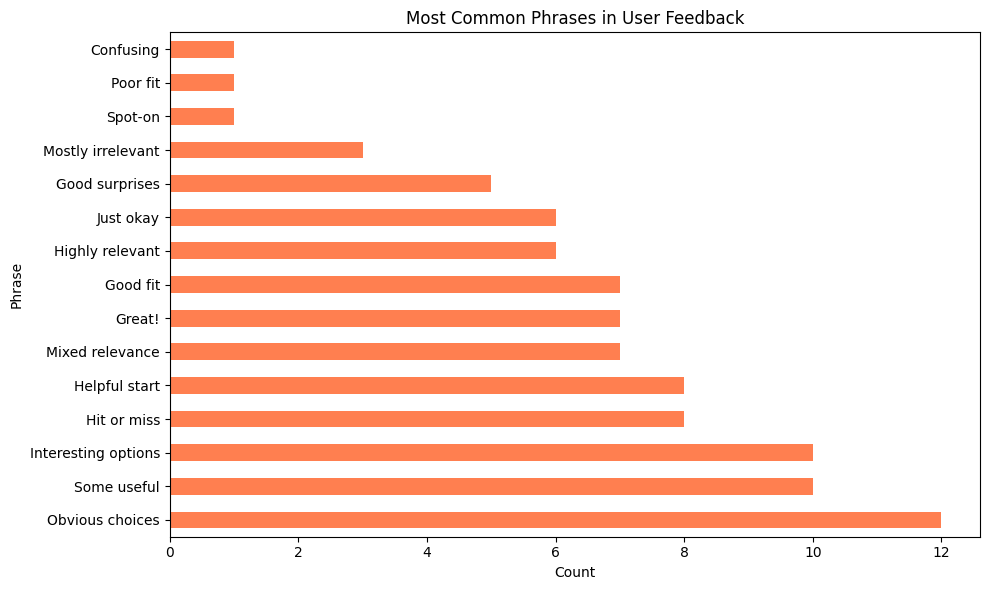

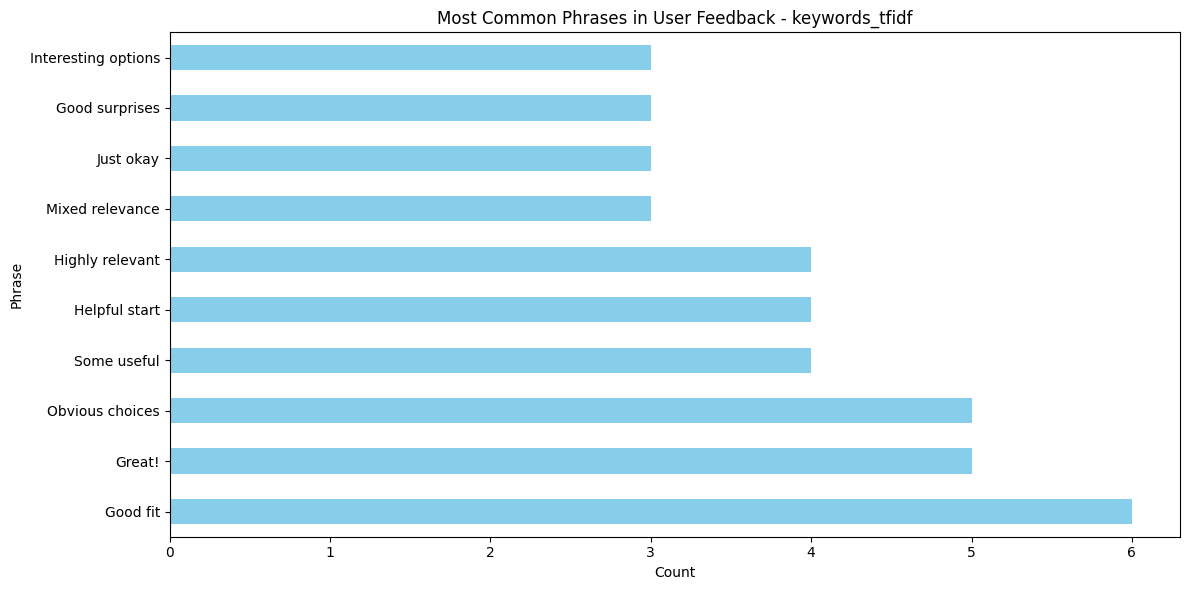

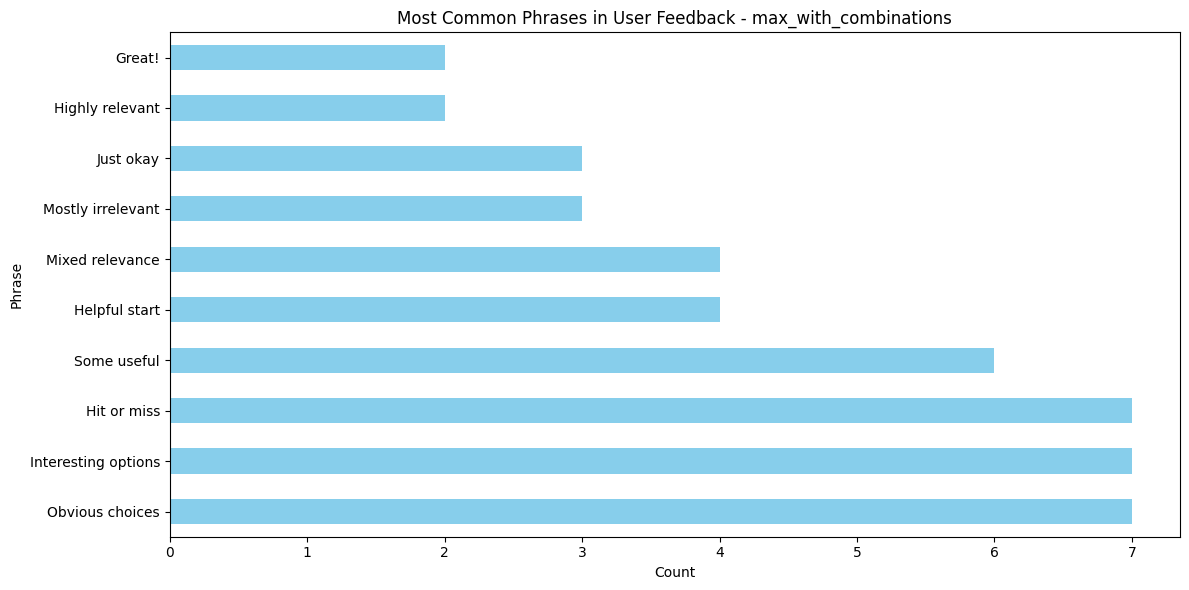

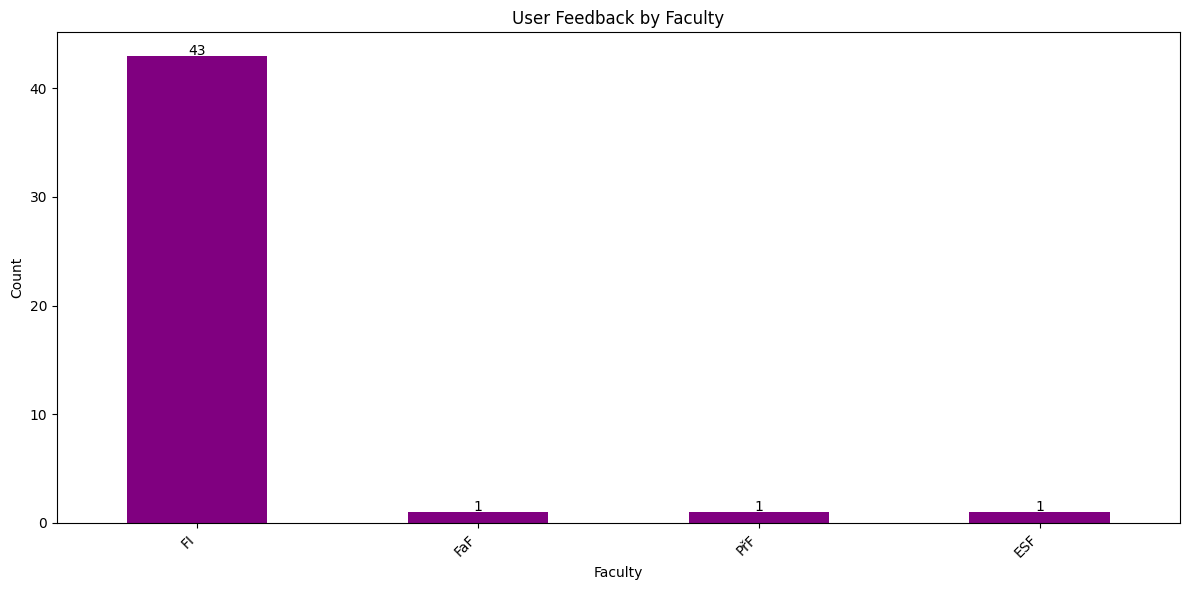

In [86]:
# Analyze user feedback data
print("Analyzing user feedback data...")

# Get user feedback data from MongoDB
user_feedbacks = list(db.user_feedback.find())

feedback_data = []
for feedback in user_feedbacks:
    try:
        feedback_data.append({
            'user_id': feedback['user_id'],
            'model': feedback['model'],
            'faculty': feedback.get('faculty'),
            'study_type': feedback.get('study_type'),
            'semester': feedback.get('semester'),
            'phrases': feedback.get('phrases', []),
            'text': feedback.get('text')
        })
    except KeyError as e:
        print(f"Missing key in feedback: {e}")
        continue

feedback_df = pd.DataFrame(feedback_data)

print(f"Total user feedback entries: {len(feedback_df)}")

# Analyze common phrases if available
if 'phrases' in feedback_df.columns and not all(x is None or len(x) == 0 for x in feedback_df['phrases']):
    # Flatten the list of phrases
    all_phrases = [phrase for phrases in feedback_df['phrases'] if phrases for phrase in phrases]

    # Overall phrase counts
    phrase_counts = pd.Series(all_phrases).value_counts().head(15)
    plt.figure(figsize=(10, 6))
    ax = phrase_counts.plot(kind='barh', color='coral')
    plt.title('Most Common Phrases in User Feedback')
    plt.xlabel('Count')
    plt.ylabel('Phrase')
    plt.tight_layout()
    plt.show()
    
    # Create a dictionary to store phrases by model
    phrases_by_model = {}
    
    # Group feedback by model and collect phrases
    for model, group in feedback_df.groupby('model'):
        model_phrases = [phrase for phrases in group['phrases'] if phrases for phrase in phrases]
        if model_phrases:
            phrases_by_model[model] = pd.Series(model_phrases).value_counts().head(10)
    
    # Plot phrases for each model
    for model, model_phrase_counts in phrases_by_model.items():
        if not model_phrase_counts.empty:
            plt.figure(figsize=(12, 6))
            ax = model_phrase_counts.plot(kind='barh', color='skyblue')
            plt.title(f'Most Common Phrases in User Feedback - {model}')
            plt.xlabel('Count')
            plt.ylabel('Phrase')
            plt.tight_layout()
            plt.show()

# Analyze feedback by faculty if available
if 'faculty' in feedback_df.columns and not feedback_df['faculty'].isna().all():
    # Replace empty strings with None
    feedback_df['faculty'] = feedback_df['faculty'].replace('', None)
    # Drop None values before counting
    faculty_counts = feedback_df['faculty'].dropna().value_counts()
    faculty_counts = feedback_df['faculty'].value_counts()
    
    plt.figure(figsize=(12, 6))
    ax = faculty_counts.plot(kind='bar', color='purple')
    plt.title('User Feedback by Faculty')
    plt.xlabel('Faculty')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    
    # Add count labels on top of bars
    for i, count in enumerate(faculty_counts):
        plt.text(i, count + 0.1, str(count), ha='center')
    
    plt.tight_layout()
    plt.show()


